<a href="https://colab.research.google.com/github/HamedFarahani89/AI-Lab/blob/main/Anomaly_detection_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ECG5000 dataset.
- 5,000 Electrocardiograms, each with 140 data points.
- labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### Load ECG data

In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
raw_data = dataframe.values
raw_data

array([[-0.11252183, -2.8272038 , -3.7738969 , ...,  0.92528624,
         0.19313742,  1.        ],
       [-1.1008778 , -3.9968398 , -4.2858426 , ...,  1.1196209 ,
        -1.4362499 ,  1.        ],
       [-0.56708802, -2.5934502 , -3.8742297 , ...,  0.90422673,
        -0.42179659,  1.        ],
       ...,
       [-1.1229693 , -2.2529248 , -2.8676281 , ..., -2.0083694 ,
        -1.8083338 ,  0.        ],
       [-0.54770461, -1.8895451 , -2.8397786 , ...,  1.1504486 ,
         0.80493225,  0.        ],
       [-1.3517791 , -2.2090058 , -2.5202247 , ..., -1.577823  ,
        -0.68453092,  0.        ]])

In [ ]:
# labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

### Normalize the data to [0,1].

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

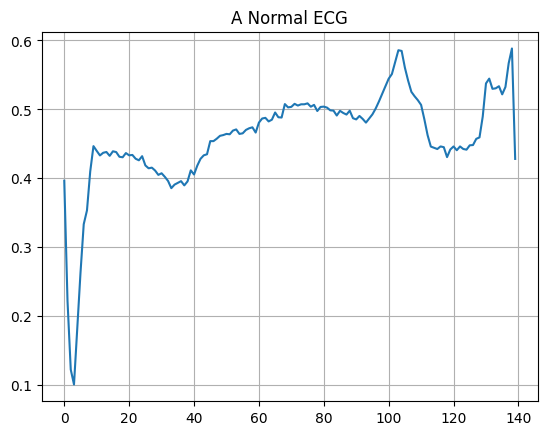

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[50 ])
plt.title("A Normal ECG")
plt.show()

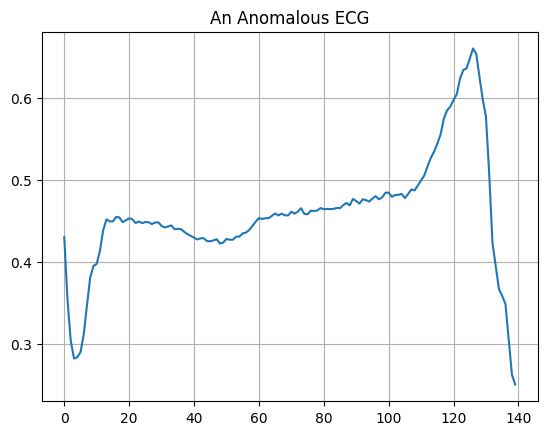

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 44ms/step - loss: 0.0155 - val_loss: 0.0282
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0155 - val_loss: 0.0281
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 0.0281
Epoch 4/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0155 - val_loss: 0.0282
Epoch 5/20
5/5 [==============================] - 0s 34ms/step - loss: 0.0155 - val_loss: 0.0284
Epoch 6/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0156 - val_loss: 0.0282
Epoch 7/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0155 - val_loss: 0.0280
Epoch 8/20
5/5 [==============================] - 0s 47ms/step - loss: 0.0155 - val_loss: 0.0280
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0155 - val_loss: 0.0283
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0155 - val_loss: 0.0280
Epoch 11/20
5/5 [=============

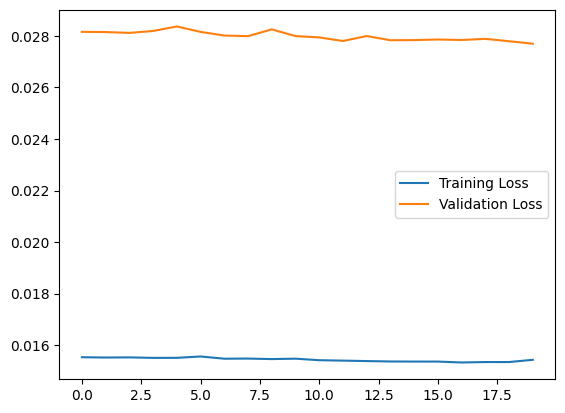

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

### First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

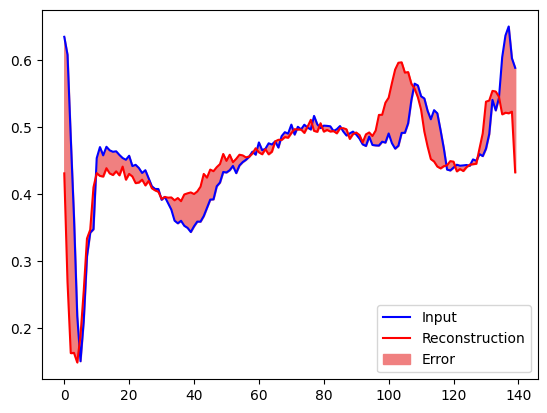

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[20], 'b')
plt.plot(decoded_data[20], 'r')
plt.fill_between(np.arange(140), decoded_data[20], normal_test_data[20], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 1ms/step


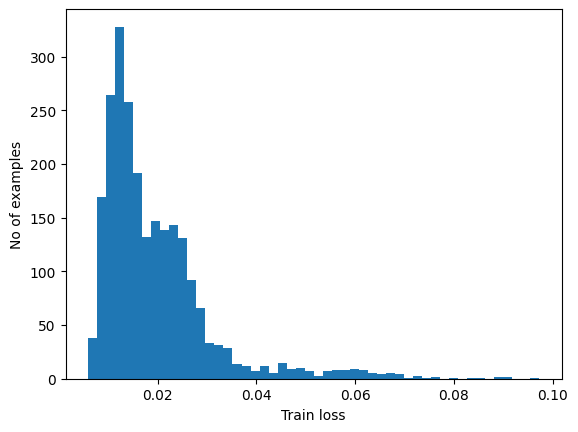

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

### try with anomalous test example.

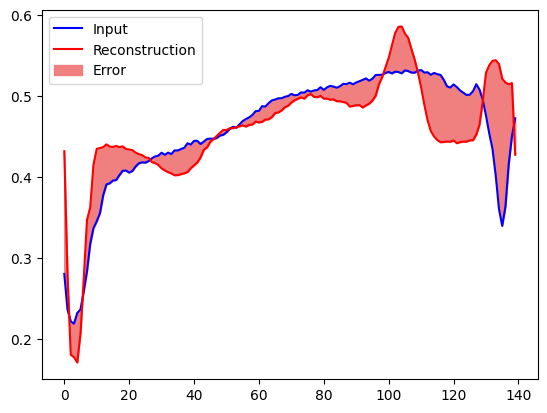

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[10], 'b')
plt.plot(decoded_data[10], 'r')
plt.fill_between(np.arange(140), decoded_data[10], anomalous_test_data[10], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

14/14 [==============================] - 0s 1ms/step


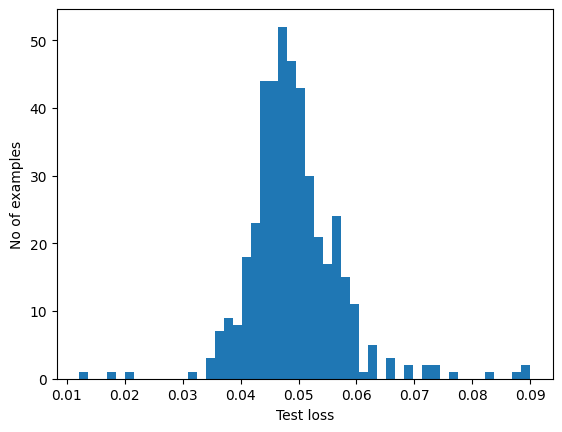

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()